In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                             plot_confusion_matrix,ConfusionMatrixDisplay,f1_score )


from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

import joblib 

In [2]:
df = pd.read_csv('data/dataset2.csv')
df.head()

,cod_municipio,ph,materia_organica,fosforo,azufre,aluminio,calcio,magnesio,potasio,sodio,...,riego_gravedad,riego_manguera,riego_microaspersión,riego_no_cuenta_con_riego,riego_no_indica,riego_por_inundación,cultivos_agrupados,latitud,longitud,altitud
0,25286,5.42,23.678298,14.083512,109.913793,0.288659,10.539840,3.347245,2.696813,0.251569,...,0,0,0,0,0,0,pastos,4.743997,-74.19866,2554.12
1,25286,5.48,18.840646,53.698736,64.177852,0.000000,9.998246,3.434139,1.802152,0.318265,...,0,0,0,0,1,0,pastos,4.743997,-74.19866,2554.12
2,25286,4.96,6.213091,199.065396,43.465909,1.309214,6.421178,0.928322,1.222704,0.070000,...,0,0,0,0,1,0,papa de año,4.743997,-74.19866,2554.12
3,25286,6.37,16.532814,35.452412,16.287313,0.000010,18.180895,5.783184,0.564649,1.378223,...,0,0,0,0,0,0,pastos,4.743997,-74.19866,2554.12
4,25286,6.23,7.910850,233.052035,29.363636,0.000010,12.109617,3.911334,1.713867,0.136932,...,0,0,0,1,0,0,pastos,4.743997,-74.19866,2554.12


### Spliting the Data


In [3]:
X = df.drop(['cultivos_agrupados','cod_municipio','cice'], axis=1)
y = df['cultivos_agrupados']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

### One hot encoding for response variable

In [170]:
encoder = preprocessing.LabelEncoder()

# encoding train labels 
encoder.fit(y_train)
y_train_encoder = encoder.transform(y_train)

# encoding test labels 
encoder.fit(y_test)
y_test_encoder = encoder.transform(y_test)

# Model implementation with imbalanced classes

After pplying hyperparameter tuning to our model we selected the folowwing parameters for our model 

In [198]:
xgbc = XGBClassifier(learning_rate=0.15, max_depth=40, min_child_weight=1, colsample_bytree=1,
                     n_estimators=150, objective='binary:logitraw').fit(X_train, y_train_encoder)

model_accuracy = round(xgbc.score(X_test, y_test_encoder), 4)
print('Mean accuracy validation: %0.4f' % (model_accuracy))

model_accuracy_train = round(xgbc.score(X_train, y_train_encoder), 4)
print('Mean accuracy training: %0.4f' % (model_accuracy_train))


Mean accuracy validation: 0.8417
Mean accuracy training: 1.0000


### Confusion matrix and classification report

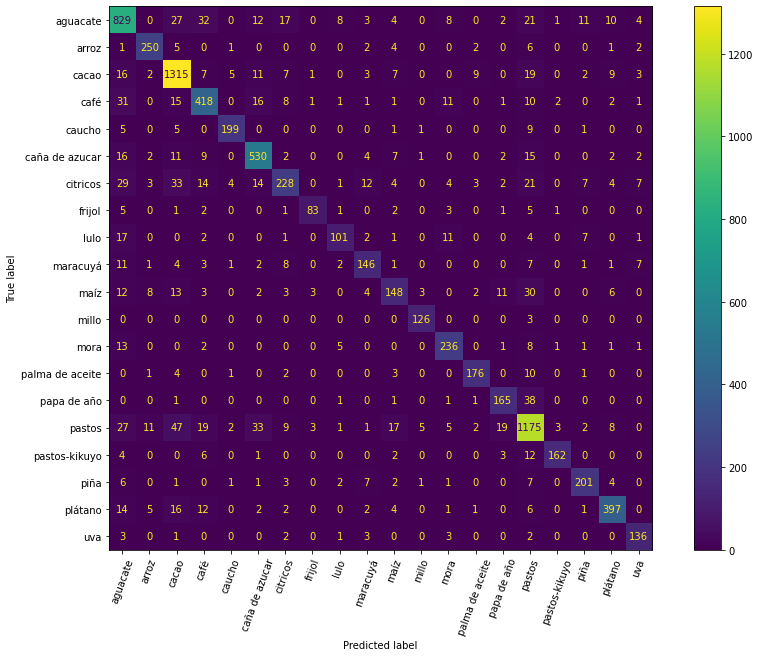

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       989
           1       0.88      0.91      0.90       274
           2       0.88      0.93      0.90      1416
           3       0.79      0.81      0.80       519
           4       0.93      0.90      0.91       221
           5       0.85      0.88      0.86       603
           6       0.78      0.58      0.67       390
           7       0.91      0.79      0.85       105
           8       0.81      0.69      0.75       147
           9       0.77      0.75      0.76       195
          10       0.71      0.60      0.65       248
          11       0.92      0.98      0.95       129
          12       0.83      0.88      0.85       269
          13       0.90      0.89      0.89       198
          14       0.80      0.79      0.80       208
          15       0.83      0.85      0.84      1389
          16       0.95      0.85      0.90       190
          17       0.86    

In [200]:
y_pred = xgbc.predict(X_test)
cm = confusion_matrix(y_test_encoder, y_pred, labels=xgbc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=encoder.classes_)
fig, ax = plt.subplots(figsize=(15,10))
disp.plot(ax=ax)
plt.xticks(rotation=70)
plt.show()
print(classification_report(y_test_encoder,y_pred))

## Model implementation with balanced classes

We used different techniques to balance our classes, finally we decided to implement SMOTETomek, since it implement under-over sampling

In [177]:
from imblearn.combine import SMOTETomek 
from imblearn.under_sampling import TomekLinks

In [201]:
os_us = SMOTETomek(random_state=42)
X, y = os_us.fit_resample(X_train, y_train_encoder)

In [196]:
xgbc = XGBClassifier(learning_rate=0.15, max_depth=40, min_child_weight=1, colsample_bytree=1,
                     n_estimators=150, objective='binary:logitraw').fit(X, y)

model_accuracy = round(xgbc.score(X_test, y_test_encoder), 4)
print('Mean accuracy validation: %0.4f' % (model_accuracy))

model_accuracy_train = round(xgbc.score(X, y), 4)
print('Mean accuracy training: %0.4f' % (model_accuracy_train))

Mean accuracy validation: 0.8341
Mean accuracy training: 1.0000


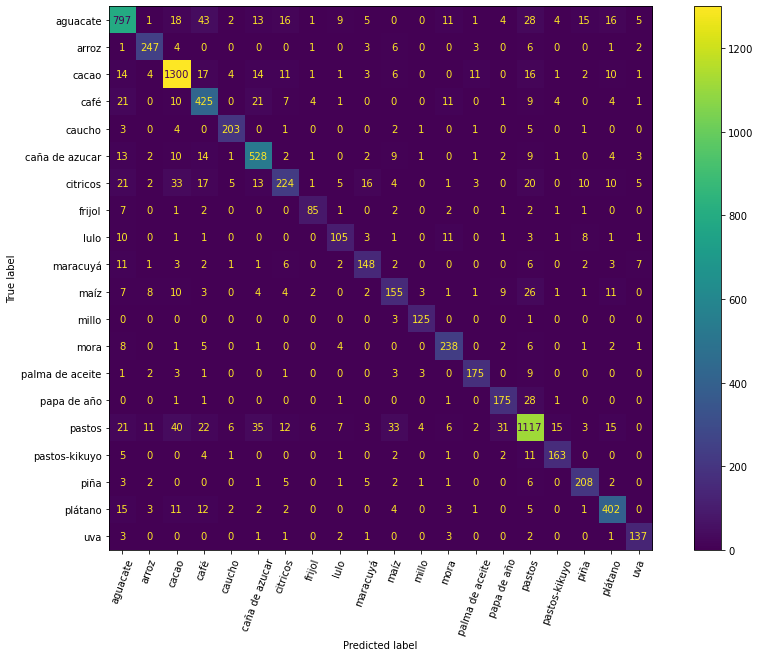

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       989
           1       0.87      0.90      0.89       274
           2       0.90      0.92      0.91      1416
           3       0.75      0.82      0.78       519
           4       0.90      0.92      0.91       221
           5       0.83      0.88      0.85       603
           6       0.77      0.57      0.66       390
           7       0.83      0.81      0.82       105
           8       0.75      0.71      0.73       147
           9       0.77      0.76      0.77       195
          10       0.66      0.62      0.64       248
          11       0.91      0.97      0.94       129
          12       0.82      0.88      0.85       269
          13       0.88      0.88      0.88       198
          14       0.77      0.84      0.80       208
          15       0.85      0.80      0.83      1389
          16       0.85      0.86      0.85       190
          17       0.82    

In [197]:
y_pred = xgbc.predict(X_test)
cm = confusion_matrix(y_test_encoder, y_pred, labels=xgbc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=encoder.classes_)
fig, ax = plt.subplots(figsize=(15,10))
disp.plot(ax=ax)
plt.xticks(rotation=70)
plt.show()
print(classification_report(y_test_encoder,y_pred))

It was no possible to improve our performance, so we decided to continue with the imbalanced classes

In [13]:
joblib.dump(xgbc, 'modelo_entrenado.pkl') # saving the model.

In [14]:
model = joblib.load('modelo_entrenado.pkl') #loading the model.

### Testing the model

In [84]:
prueba1=X_test.iloc[2]

In [85]:
prueba1=pd.DataFrame(prueba1).transpose()
probabilidad=model.predict_proba(prueba1)

In [86]:
pred=model.predict(prueba1)

In [111]:
clases=encoder.classes_

In [112]:
cont=0
val={}
for prob in probabilidad[0]:
    val[clases[cont]]=prob
    cont=cont+1

In [142]:
sortedDict = sorted(val.items(), key=operator.itemgetter(1))

In [160]:
sortedDict[15:20][4][0]

'café'

In [161]:
import operator
probabilidades=model.predict_proba(X)
clases=encoder.classes_
cont=0
val={}
for prob in probabilidades[0]:
    val[clases[cont]]=prob
    cont=cont+1
sortedDict = sorted(val.items(), key=operator.itemgetter(1))
cultivos=[]
cultivos.append(sortedDict[15:20][4][0])
cultivos.append(sortedDict[15:20][3][0])
cultivos.append(sortedDict[15:20][2][0])
cultivos.append(sortedDict[15:20][1][0])
cultivos.append(sortedDict[15:20][0][0])

## Cultivos contiene los 5 cultivos recomendados en orden